In [12]:
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io

wav_fname = pjoin('./data/free-spoken-digit/dev/1031_9.wav')

In [13]:
samplerate, data = wavfile.read(wav_fname)
print(f"number of channels = {data.shape}")
length = data.shape[0] / samplerate
print(f"length = {length}s")

number of channels = (4062,)
length = 0.50775s


In [14]:
data, samplerate

(array([-256,    0, -256, ..., -512, -256, -512], dtype=int16), 8000)

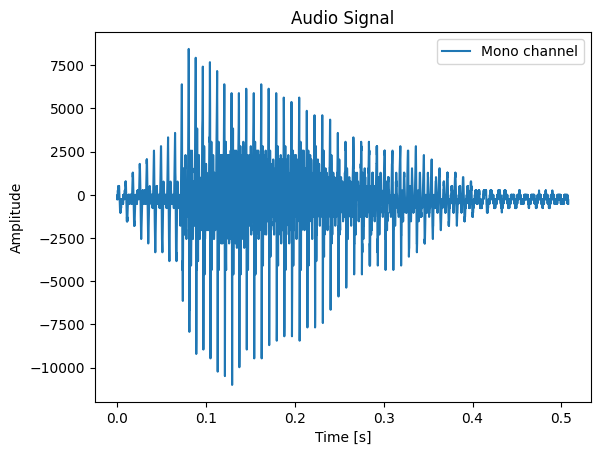

In [15]:
import matplotlib.pyplot as plt
import numpy as np

time = np.linspace(0., length, data.shape[0])

if len(data.shape) == 1:  
    plt.plot(time, data, label="Mono channel")
else: 
    plt.plot(time, data[:, 0], label="Left channel")
    plt.plot(time, data[:, 1], label="Right channel")

plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Audio Signal")
plt.show()


In [16]:
import os
from scipy.io import wavfile

folder_path = "./data/free-spoken-digit/dev"  

files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

for file in files:
    file_path = os.path.join(folder_path, file)
    sampling_rate, data = wavfile.read(file_path)
    print(f"File: {file}")
    print(f"Sampling Rate: {sampling_rate}")
    print(f"Data Shape: {data}")
    print("-------")

File: 481_8.wav
Sampling Rate: 8000
Data Shape: [ 362  360  356 ... -168  -56  318]
-------
File: 863_1.wav
Sampling Rate: 8000
Data Shape: [ 3  6 -2 ... 13  6  6]
-------
File: 845_2.wav
Sampling Rate: 8000
Data Shape: [-21  31 -34 ...  -4   9  34]
-------
File: 1146_3.wav
Sampling Rate: 8000
Data Shape: [  0   8 -17 ...  19   9   2]
-------
File: 307_2.wav
Sampling Rate: 8000
Data Shape: [   0    0 -256 ... -512 -512 -768]
-------
File: 1281_5.wav
Sampling Rate: 8000
Data Shape: [  0   0 -14 ... -12  -8 -13]
-------
File: 223_6.wav
Sampling Rate: 8000
Data Shape: [-2  0 -2 ... 16 17 -6]
-------
File: 1468_4.wav
Sampling Rate: 8000
Data Shape: [   0    0    0 ...    0    0 -256]
-------
File: 793_2.wav
Sampling Rate: 8000
Data Shape: [-3 -1 -3 ... 19 10  5]
-------
File: 939_3.wav
Sampling Rate: 8000
Data Shape: [  6   5 -22 ... -66 -38 -43]
-------
File: 657_3.wav
Sampling Rate: 8000
Data Shape: [ 320  147  -21 ... -304 -241 -330]
-------
File: 1300_4.wav
Sampling Rate: 8000
Data Sha

In [17]:
def load_wav_files(folder_path, labeled=True):
    data, labels = [], []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            path = os.path.join(folder_path, file_name)
            sampling_rate, signal = wavfile.read(path)
            data.append(signal)
            if labeled:
                label = int(file_name.split('_')[1].split('.')[0]) 
                labels.append(label)
    return (data, labels) if labeled else data

dev_folder = "./data/free-spoken-digit/dev"
eval_folder = "./data/free-spoken-digit/eval"

X_train_raw, y_train = load_wav_files(dev_folder)
X_eval_raw = load_wav_files(eval_folder, labeled=False)

In [18]:
def normalize_length(signals, target_length):
    return [
        np.pad(signal, (0, max(0, target_length - len(signal))), 'constant')[:target_length]
        for signal in signals
    ]

target_length = max(len(signal) for signal in X_train_raw)
X_train_raw = normalize_length(X_train_raw, target_length)
X_eval_raw = normalize_length(X_eval_raw, target_length)

In [19]:
def extract_features_advanced(signals):
    features = []
    for signal in signals:
        mean = np.mean(signal)
        std = np.std(signal)
        max_val = np.max(signal)
        min_val = np.min(signal)
        skewness = np.mean((signal - mean) ** 3) / (std ** 3)
        kurtosis = np.mean((signal - mean) ** 4) / (std ** 4)
        features.append([mean, std, max_val, min_val, skewness, kurtosis])
    return np.array(features)

In [20]:
def extract_frequency_features(signals):
    features = []
    for signal in signals:
        fft_signal = np.fft.fft(signal)
        power_spectrum = np.abs(fft_signal) ** 2
        mean_power = np.mean(power_spectrum)
        std_power = np.std(power_spectrum)
        features.append([mean_power, std_power])
    return np.array(features)

In [21]:
import librosa

def extract_mfcc_features(signals, sample_rate, n_mfcc=13):
    features = []
    for signal in signals:
        # Преобразуем сигнал в тип float32
        signal = signal.astype(np.float32)

        # Масштабируем значения в диапазон [-1, 1], если данные не нормализованы
        signal = signal / np.max(np.abs(signal))
        
        # Вычисляем MFCC
        mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)
        features.append(np.mean(mfcc, axis=1))  # Берем средние значения MFCC
    return np.array(features)


ModuleNotFoundError: No module named 'librosa'

In [22]:
# Извлекаем признаки
samplerate = 8000  # Задаем частоту дискретизации
X_train_features = extract_features_advanced(X_train_raw)
X_eval_features = extract_features_advanced(X_eval_raw)

freq_features_train = extract_frequency_features(X_train_raw)
freq_features_eval = extract_frequency_features(X_eval_raw)

mfcc_features_train = extract_mfcc_features(X_train_raw, samplerate)
mfcc_features_eval = extract_mfcc_features(X_eval_raw, samplerate)


NameError: name 'extract_mfcc_features' is not defined

In [39]:
from sklearn.preprocessing import StandardScaler

X_train_features = np.hstack([X_train_features, freq_features_train, mfcc_features_train])
X_eval_features = np.hstack([X_eval_features, freq_features_eval, mfcc_features_eval])

scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_eval_features = scaler.transform(X_eval_features)


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train_split, y_val = train_test_split(X_train_features, y_train)


In [41]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.1, random_state=42)
clf.fit(X_train, y_train_split)
y_pred = clf.predict(X_val)

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 

f1 = f1_score(y_val, y_pred, average='weighted')
accuracy = accuracy_score(y_val, y_pred)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

F1 Score: 0.9462667155175966
Accuracy: 0.9466666666666667


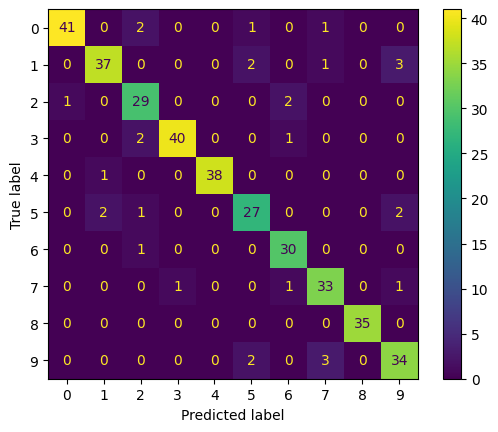

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Визуализация матрицы ошибок ---
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [25]:
y_eval_pred = clf.predict(X_eval_features)

In [27]:
import pandas as pd

eval_ids = [f.split('.')[0] for f in os.listdir(eval_folder) if f.endswith('.wav')]
submission = pd.DataFrame({'Id': eval_ids, 'Predicted': y_eval_pred})

submission['Id'] = submission['Id'].astype(int)

submission = submission.sort_values(by='Id')

submission.to_csv('submission.csv', index=False)

print("Упорядоченный файл 'submission.csv' создчан.")

Упорядоченный файл 'submission.csv' создан.
